## Binary classification with Lightweight CNN

The paths utilized are defiend in the `path_module.py`

Before this, the data must be processed. 
- `data_processing` notebook loads raw data and prepares training,validation and test dataset


### 1. Import libraries

In [9]:
from modules.path_module import *
from modules.utils_module import *
import os
import joblib
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Load data

In [3]:
train_data=joblib.load(os.path.join(processed_datapath,"train_data.joblib"))
test_data=joblib.load(os.path.join(processed_datapath,"test_data.joblib"))
val_data=joblib.load(os.path.join(processed_datapath,"val_data.joblib"))

### 3. Prepare data 
- We train using the training set and save the model that gives the best performance on the validation set

In [4]:
train_sigdata,train_label=prepare_cnn_data(train_data)
val_sigdata,val_label=prepare_cnn_data(val_data)
test_sigdata,test_label=prepare_cnn_data(test_data)

### 4. Lightweight CNN model

Let's define our simple CNN architecture which has one conv layer and one FC layer

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_Model(nn.Module):
    def __init__(self,chan_total,signal_length):
        super(CNN_Model, self).__init__()
        self.stride=1
        self.k_val=5
        # conv: (chan x signal)--> (chan x signal/stride)
        self.conv1 = nn.Conv1d(in_channels=chan_total, out_channels=chan_total, kernel_size=2*self.k_val+self.stride, stride=self.stride,padding=self.k_val) #k=lpc order ?#oc=2,k=4
        # pool: (chan x signal/stride) --> (chan x 1)
        self.pool1 = nn.AvgPool1d(kernel_size=int(signal_length/self.stride))
        self.input_s=int(chan_total)
        self.fc = nn.Linear(self.input_s, 2)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.pool1(x)
        x = x.view(-1, self.input_s)
        x=self.fc(x)
        return x

### 5. Initialize model

In [6]:
import torch.optim as optim
from torch import cuda

# Set the random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# use GPU
device='cpu'#'cuda' if cuda.is_available() else 'cpu'
print("Running on: "+device)
cuda.empty_cache()

# initialize model
n_chan=train_data[0].data.shape[1]
n_datalength=train_data[0].data.shape[0]
model = CNN_Model(n_chan,n_datalength)
model.to(device)
print('Model created')

Running on: cpu
Model created


### 6. Load trained model

In [7]:
cnn_modelfullpath=os.path.join(cnn_modelpath,'light_cnn.pt')
best_model_state=torch.load(cnn_modelfullpath, map_location=device)
model.load_state_dict(best_model_state,strict=True)
model.eval()
print('Fine tune model loaded')


Fine tune model loaded


### 7. Pooling layer isnpection

First let's create a hook to inspect the pooling layer output

In [129]:
# Create example input data
input_data = torch.randn(2, 59, 2500)

def get_flat_output(model,input_data):
    # Container to store the output of the flatten layer
    flattened_output = []

    # Define a hook function to capture the output
    def hook_fn(module, input, output):
        flattened_output.append(output)

    # Register the hook on the flatten operation, which is the view() operation
    # In this case, we'll hook it to the output of the pooling layer before the view operation
    hook_handle = model.pool1.register_forward_hook(hook_fn)

    # Forward pass through the model
    _ = model(input_data)

    # Remove the hook after getting the output
    hook_handle.remove()

    # The flattened output is now stored in the flattened_output list
    #print(flattened_output[0].shape)  # Should match the flattened vector size

    # If needed, convert the output to numpy for further processing
    flattened_output_np = flattened_output[0].detach().cpu().numpy().squeeze()
    return flattened_output_np

foutput=get_flat_output(model,input_data)
print(foutput)

[[0.323189   0.3250776  0.34068877 0.29230225 0.37339926 0.26622614
  0.39916584 0.2709356  0.30152133 0.34579122 0.38621697 0.31471348
  0.30584803 0.38798448 0.39156258 0.40576205 0.3271362  0.33656082
  0.3254681  0.3147087  0.29621932 0.38762772 0.31912738 0.44478706
  0.37315142 0.28824183 0.35502318 0.35062188 0.41373965 0.37184322
  0.37085813 0.2895747  0.4177233  0.37937987 0.34102002 0.27132997
  0.43883866 0.29576173 0.40181205 0.3556144  0.26198816 0.3518448
  0.3313108  0.33648124 0.30220267 0.42184898 0.34134418 0.36590838
  0.2836469  0.34194306 0.30647907 0.36603504 0.37152272 0.427223
  0.32599944 0.33628199 0.37382987 0.38371566 0.31293648]
 [0.34511018 0.336477   0.38672048 0.30143338 0.37727726 0.31383553
  0.37379998 0.26298663 0.3388178  0.349078   0.38012442 0.31964153
  0.30138847 0.39234546 0.38767743 0.401533   0.31763646 0.3695246
  0.38588095 0.35712188 0.3053886  0.364248   0.27999905 0.4694639
  0.36924115 0.26894656 0.36350846 0.39751062 0.3968485  0.3522

Now generate synthetic data for each frequency and get the output of the pooling layer

In [230]:
# def feature_interprete(model):
# Create a new model to extract the flattened layer output
nchan=59

# Define the frequency range from 1 Hz to 50 Hz
min_frequency = 1
max_frequency = 245

# Define the sampling rate
sampling_rate = 500  # Hz

# Create an array to store the frequencies
frequencies = np.arange(min_frequency, max_frequency + 1,1)

# Create a time array from 0 to 5 second at the given sampling rate
t = np.linspace(0, 5, 5*sampling_rate)

ntime=100
foutput_all=np.empty((ntime,len(frequencies),nchan))
for k in range(ntime):
    # Initialize an empty 2D array to store the sinusoids
    rand_signals = np.empty((len(frequencies),nchan, len(t)))
    rand_signals=torch.tensor(rand_signals,dtype=torch.float32)
    # Generate the sinusoids for each frequency
    for i, freq in enumerate(frequencies):
        for j in range(nchan):
            # Generate a random phase
            random_phase = np.random.rand() * 2 * np.pi  # Random phase between 0 and 2π
            # Create the sinusoid with the random phase
            sig = np.sin(2 * np.pi * freq * t + random_phase)

            # Convert the sinusoid to a PyTorch tensor
            sig = torch.tensor(sig, dtype=torch.float32)
            rand_signals[i,j,:] = sig

    # get model output for the sinusoids
    foutput=get_flat_output(model,rand_signals)
    foutput_all[k,:,:]=foutput

foutput=np.mean(foutput_all,axis=0)


Show the feature plot

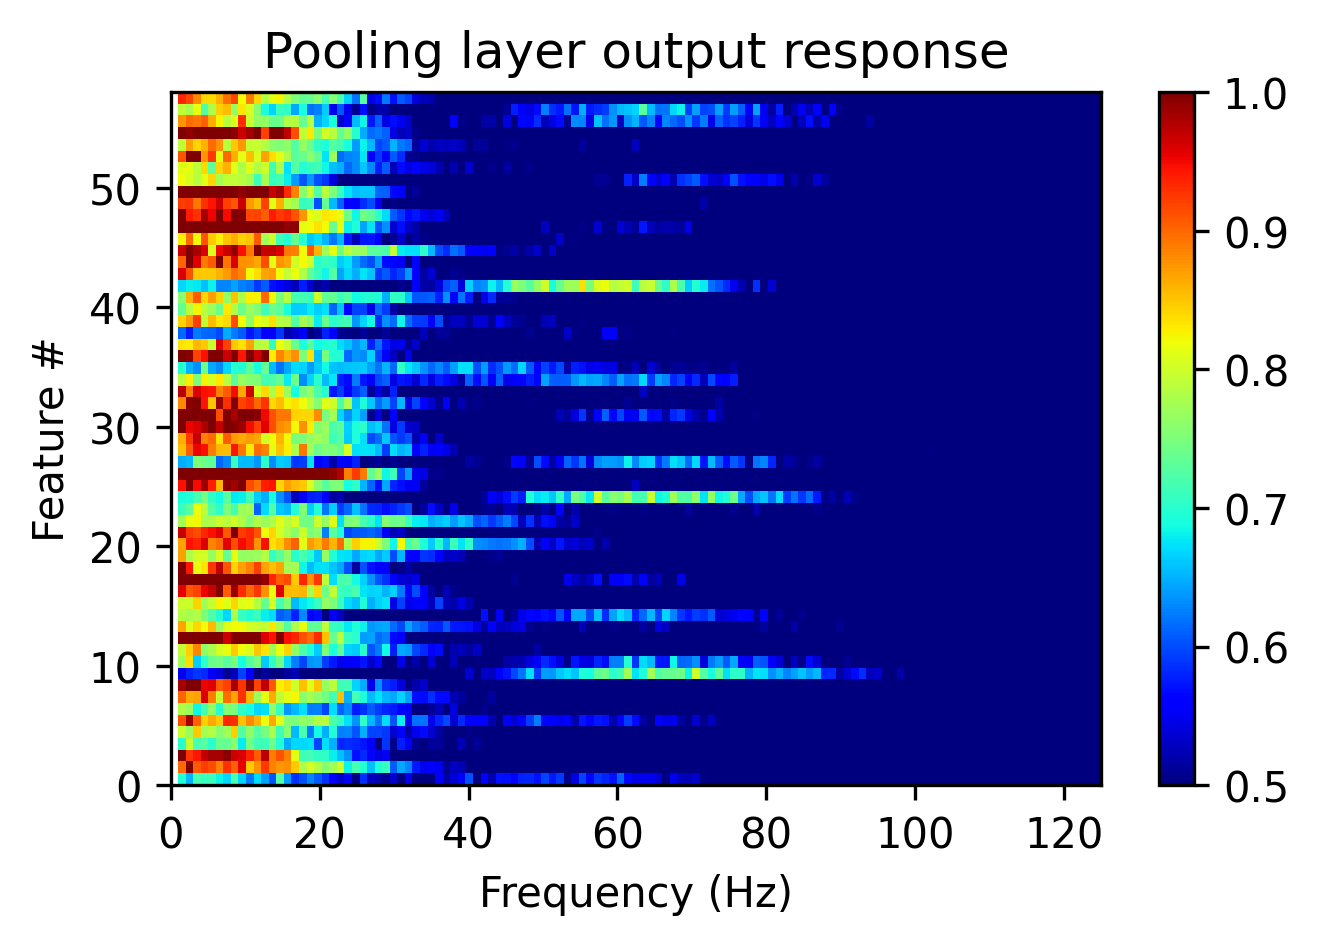

In [231]:
# normalize columnwise
flattened_output_sum = np.sum(foutput, axis=0)
flattened_output =foutput /flattened_output_sum
flattened_output=flattened_output*100

extent = [ 1,  250,0,58 ]

# Create a heatmap
plt.figure(figsize=(5, 3),dpi=300)
plt.imshow(flattened_output.T, cmap='jet',extent=extent, 
           vmin=.5,vmax=1,
           interpolation='none',aspect='auto')  # 'viridis' is just one of many available colormaps
plt.colorbar()  # Add a colorbar to the right
plt.title(r'Pooling layer output response')  # Add a title
plt.ylabel(r'Feature #')
plt.xlabel(r'Frequency (Hz)')
#plt.xticks([25,50,75,100,125,150,175,200,225])
plt.xlim([0, 125])
plt.xscale('linear')
# Show the plot
plt.show()

Example synthetic data

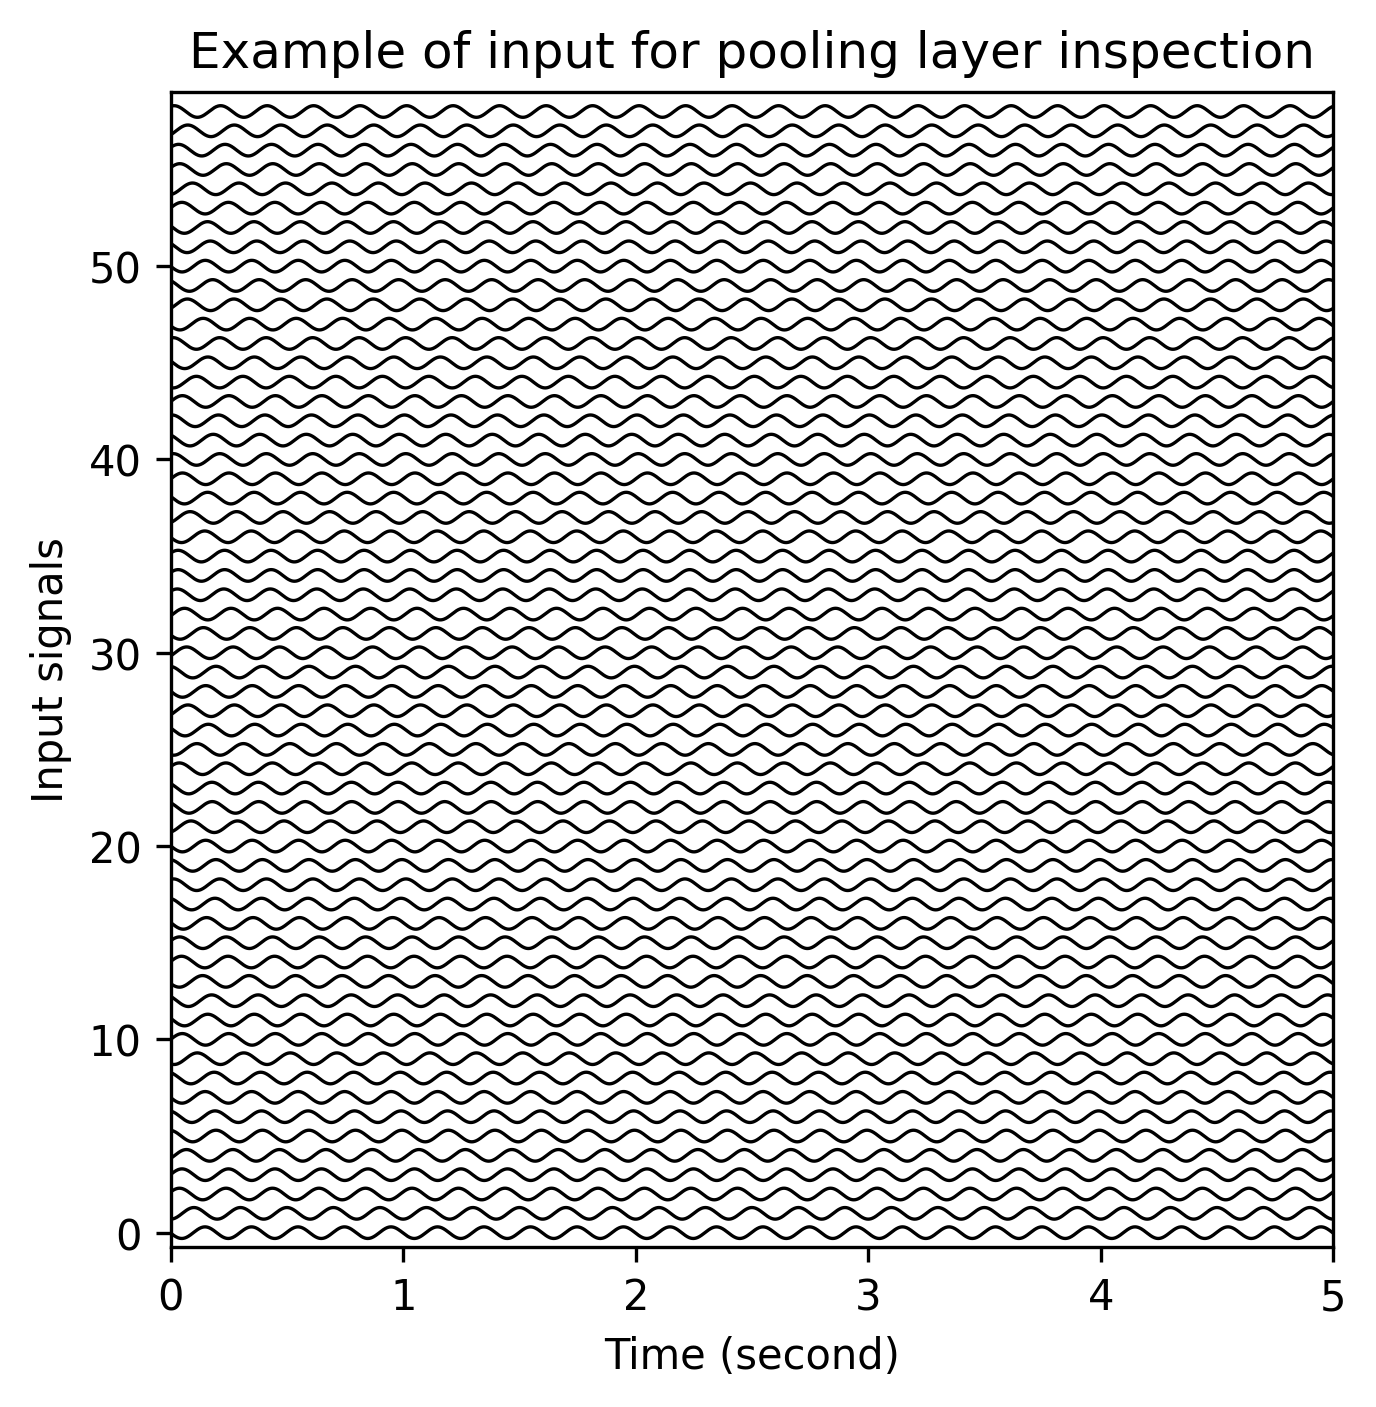

In [42]:
# Create a new model to extract the flattened layer output
nchan=59

# Define the sampling rate
sampling_rate = 500  # Hz

# Create a time array from 0 to 5 second at the given sampling rate
t = np.linspace(0, 5, 5*sampling_rate)

freq=5
plt.figure(figsize=(5, 5),dpi=300)
for j in range(nchan):
    # Generate a random phase
    random_phase = np.random.rand() * 2 * np.pi  # Random phase between 0 and 2π
    # Create the sinusoid with the random phase
    sig = np.sin(2 * np.pi * freq * t + random_phase)
    plt.plot(t,0.3*sig+j,color='black',alpha=1,linewidth=.8)

plt.xlabel(r'Time (second)')
plt.ylabel(r'Input signals')
plt.title('Example of input for pooling layer inspection')
plt.xlim([0 ,5])
plt.ylim([-.75, 59])
#plt.legend()
plt.grid(False)
plt.show()



### 8. Groupwise PSD of the training dataset

Let's create PSD comparison of PD vs control so we can understand the dataset.

First we collect timeseries of training dataset in PD and control group then we calculate PSD for each 5s epochs

In [181]:
# Parameters for the PSD calculation
fs = 500  # Sampling frequency in Hz
# Calculate PSD for each epoch
epochs0=get_group_signals(train_sigdata,train_label,0)
avg_psd0, sem_psd0, freqs0= get_PSD(epochs0,fs)
epochs1=get_group_signals(train_sigdata,train_label,1)
avg_psd1, sem_psd1, freqs1= get_PSD(epochs1,fs)

Let's plot the PSD comparison

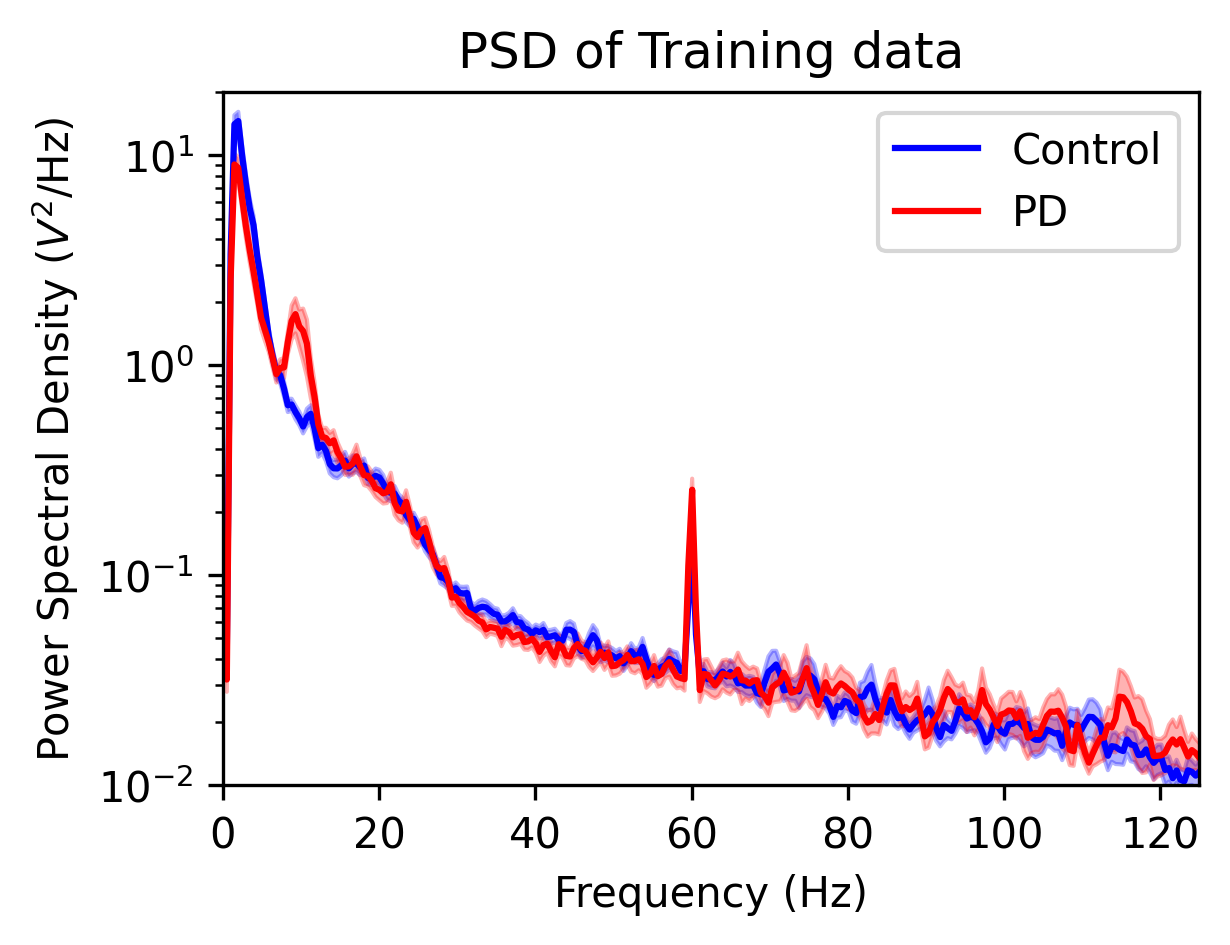

In [228]:
# Plotting the average PSD with SEM
plt.figure(figsize=(4.2, 3),dpi=300)
plt.plot(freqs0, avg_psd0, label='Control', color='blue')
plt.fill_between(freqs0, avg_psd0 - sem_psd0, avg_psd0 + sem_psd0, color='blue', alpha=0.3)
plt.plot(freqs1, avg_psd1, label='PD', color='red')
plt.fill_between(freqs1, avg_psd1 - sem_psd1, avg_psd1 + sem_psd1, color='red', alpha=0.3)
plt.xlabel(r'Frequency (Hz)')
plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
plt.title('PSD of Training data')
plt.yscale('log')
plt.xlim([0 ,125])
plt.ylim([1e-2, 20])
plt.legend()
plt.grid(False)
plt.show()

### 8. Conv layer output inspection
Let's understand what the conv layer is capturing. For this, we generate white noise signal with flat PSD as inputs.

First, let us generate a sample white noise and check the PSD

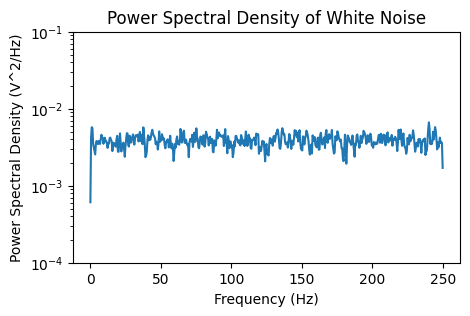

In [164]:
# Parameters
fs = 500  # Sampling frequency in Hz
duration = 30  # Duration in seconds
n_samples = fs * duration  # Total number of samples

# Generate white noise
white_noise = np.random.normal(0, 1, n_samples)

# Calculate PSD using Welch's method
freqs, psd = welch(white_noise, fs=fs, nperseg=1024)

# Plot the PSD
plt.figure(figsize=(5, 3))
plt.semilogy(freqs, psd)
plt.title('Power Spectral Density of White Noise')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V^2/Hz)')
plt.ylim([1e-4,1e-1])
plt.yscale('log')
plt.grid(False)
plt.show()

Now let's create a hook to obtain the conv layer output from the model

In [165]:
input_data = torch.randn(2, 59, 2500)

def get_conv_output(model,input_data):
    # Container to store the output of the flatten layer
    flattened_output = []

    # Define a hook function to capture the output
    def hook_fn(module, input, output):
        flattened_output.append(output)

    # Register the hook on the flatten operation, which is the view() operation
    # In this case, we'll hook it to the output of the pooling layer before the view operation
    hook_handle = model.conv1.register_forward_hook(hook_fn)

    # Forward pass through the model
    _ = model(input_data)

    # Remove the hook after getting the output
    hook_handle.remove()

    # The flattened output is now stored in the flattened_output list
    #print(flattened_output[0].shape)  # Should match the flattened vector size

    # If needed, convert the output to numpy for further processing
    flattened_output_np = flattened_output[0].detach().cpu().numpy().squeeze()
    return flattened_output_np

foutput=get_conv_output(model,input_data)
print(foutput.shape)

(2, 59, 2500)


Now Let us create white noise as signals for all input data and capture the conv layer outputs.

In [195]:
# def feature_interprete(model):
# Create a new model to extract the flattened layer output
nchan=59

# Define the sampling rate
sampling_rate = 500  # Hz
sig_length=5*sampling_rate


ntime=300
foutput_all=np.empty((ntime,nchan,sig_length))
for k in range(ntime):
    # Initialize an empty 2D array to store the sinusoids
    rand_signals = np.empty((1 ,nchan, sig_length))
    rand_signals=torch.tensor(rand_signals,dtype=torch.float32)
    # Generate the sinusoids for each frequency
    for j in range(nchan):
        # Generate a random signal
        random_sig = np.random.normal(0, 1, sig_length)
        # Convert the sinusoid to a PyTorch tensor
        sig = torch.tensor(random_sig, dtype=torch.float32)
        rand_signals[0,j,:] = sig

    # get model output for the sinusoids
    foutput=get_conv_output(model,rand_signals)
    foutput_all[k,:,:]=foutput

#foutput=np.mean(foutput_all,axis=0)


Now let us calculate the PSD of the outputs from the conv output layer and observe the filtering process done by the conv layer

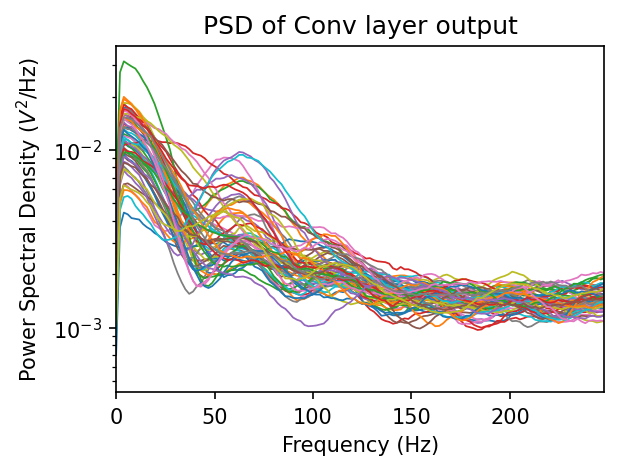

In [227]:
foutput_all.shape

plt.figure(figsize=(4.2, 3),dpi=150)

for ch in range(nchan):
    cnn_output=foutput_all[:,ch,:].squeeze()

    epochs=[]
    for i in range(ntime):
        epochs.append(cnn_output[i,:].squeeze())

    avg_psd, sem_psd, freqs= get_PSD(epochs,fs,256)
    plt.plot(freqs, avg_psd,alpha=1,linewidth=.85)

plt.xlabel(r'Frequency (Hz)')
plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
plt.title('PSD of Conv layer output')
plt.yscale('log')
plt.xlim([0 ,248])
#plt.ylim([1e-3, 1e-1])
#plt.legend()
plt.grid(False)
plt.show()

Let us see these PSDs in pallets for better comparison

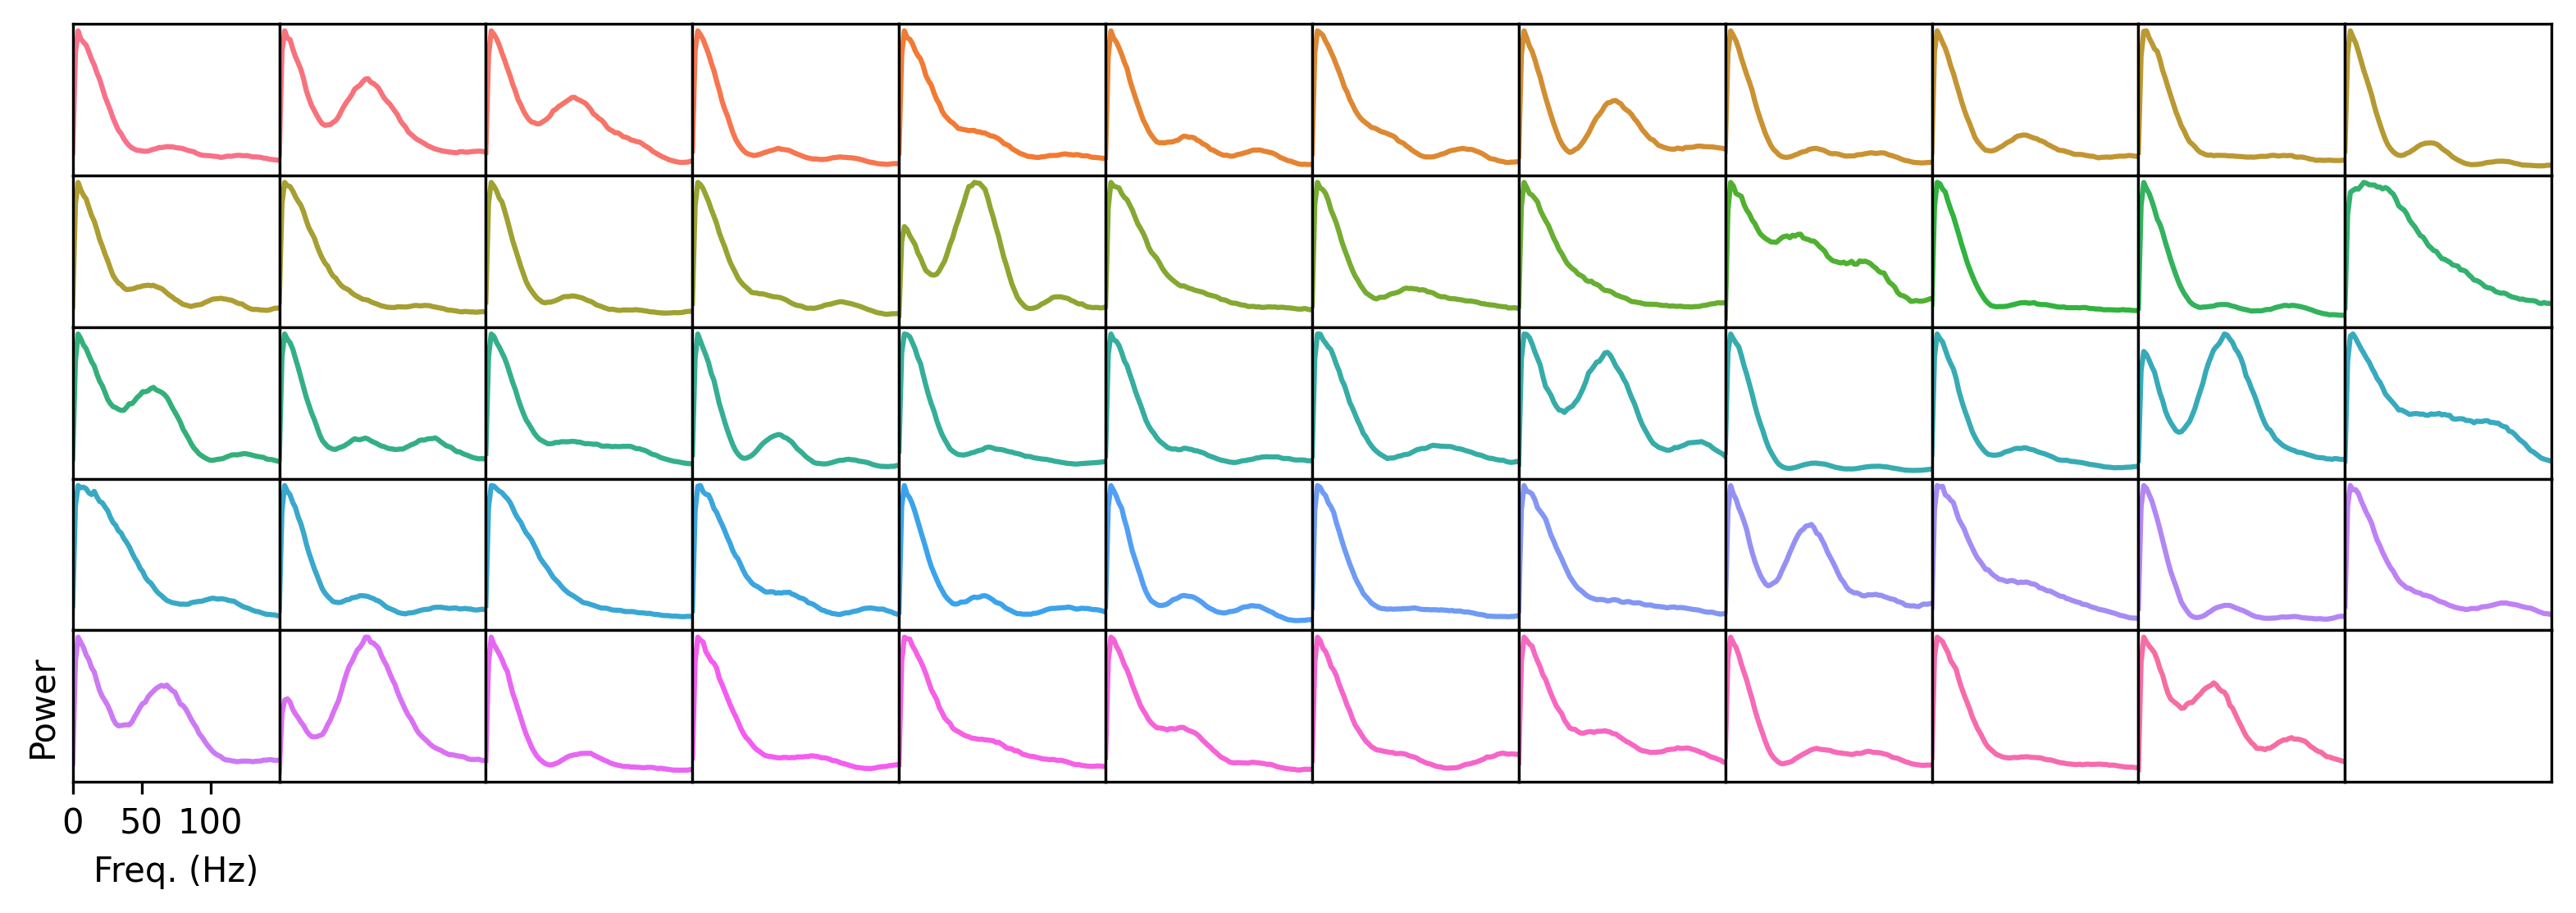

In [225]:
colors = sns.color_palette('husl', n_colors=int(60))


pcols=12
prows=60//pcols
# Create a figure and a grid of subplots
fig, axes = plt.subplots(prows, pcols, figsize=(13, 4),dpi=300)
# Adjust the spacing between plots to be zero
plt.subplots_adjust(wspace=0, hspace=0)


for ch in range(nchan):
    cnn_output=foutput_all[:,ch,:].squeeze()

    epochs=[]
    for i in range(ntime):
        epochs.append(cnn_output[i,:].squeeze())

    avg_psd, sem_psd, freqs= get_PSD(epochs,fs,256)
    c=colors[ch]
    i= ch // pcols
    j= ch % pcols

    axes[i, j].plot(freqs, avg_psd, alpha=1,color=c,linewidth=1.5)

    #plt.grid(which='both', axis='both')
    axes[i, j].set_xlim((0,150))
    #axes[i, j].set_ylim((-60,60))
    # Hide x and y axis labels, ticks, and titles
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    axes[i, j].set_xlabel('')
    axes[i, j].set_ylabel('')
    axes[i, j].set_title('')

    if i==4 and j==0:
       axes[i, j].set_xticks([0,50,100])
       axes[i, j].set_xlabel('Freq. (Hz)')
       axes[i, j].set_ylabel(r'Power') 

ch=59
i= ch // pcols
j= ch % pcols
axes[i, j].set_xticks([])
axes[i, j].set_yticks([])
axes[i, j].set_xlabel('')
axes[i, j].set_ylabel('')
axes[i, j].set_title('')

plt.show()

Example of synthetic data

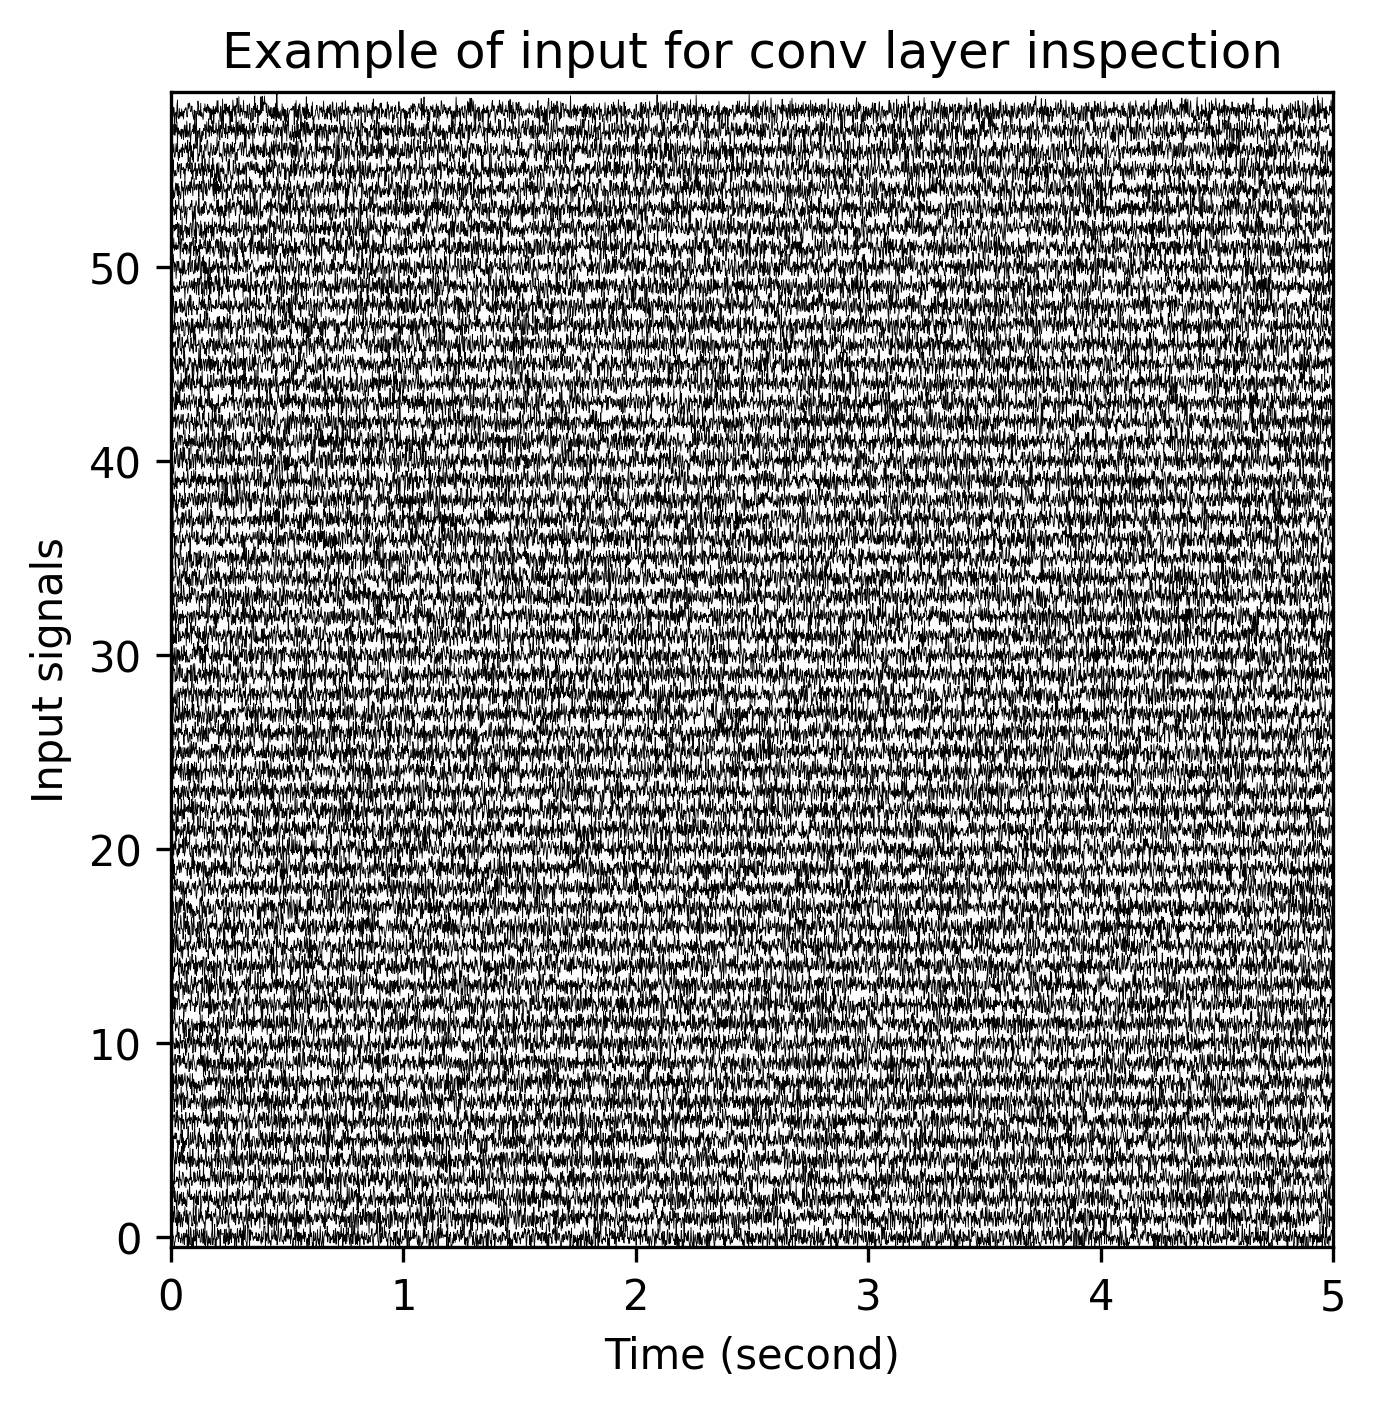

In [43]:
# Create a new model to extract the flattened layer output
nchan=59

# Define the sampling rate
sampling_rate = 500  # Hz
sig_length=5*sampling_rate
# Create a time array from 0 to 5 second at the given sampling rate
t = np.linspace(0, 5, 5*sampling_rate)

freq=3
plt.figure(figsize=(5, 5),dpi=300)
for j in range(nchan):
    # Generate a random phase
    random_phase = np.random.rand() * 2 * np.pi  # Random phase between 0 and 2π
    # Create the sinusoid with the random phase
    sig = np.random.normal(0, 1, sig_length)
    plt.plot(t,0.3*sig+j,color='black',alpha=1,linewidth=.2)

plt.xlabel(r'Time (second)')
plt.ylabel(r'Input signals')
plt.title('Example of input for conv layer inspection')
plt.xlim([0 ,5])
plt.ylim([-.5, 59])
#plt.legend()
plt.grid(False)
plt.show()